In [1]:
import sys
sys.path.append("../")

In [2]:
from src.nnsrc.dense import NeuralNetwork

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
from matplotlib.pyplot import plot, legend, show

In [5]:
data = pd.read_csv('../src/data/regression/data.cube.train.100.csv')
X = data[["x"]].values
Y = data["y"].values.reshape(-1,1)

In [6]:
test_data = pd.read_csv('../src/data/regression/data.cube.test.100.csv')
test_X = test_data[["x"]].values
test_Y = test_data['y'].values.reshape(-1,1)

In [26]:
def train(data, X, Y, test_data, test_X, test_Y, scale_x=False, scale_y=False, alpha=0.7, epochs=15000, batch_size=32, beta=0.9,
                    n_neurons_per_layer=[1, 50, 50, 50, 1], act_funcs=['relu','relu', 'relu', 'relu', 'linear'],
                    use_bias=True, problem='regression', seed=1, verbose=True):
    X = X.copy()
    Y = Y.copy()
    test_X = test_X.copy()
    test_Y = test_Y.copy()
    X_train_scaler = MinMaxScaler((0,1))
    Y_train_scaler = MinMaxScaler((0,1))
    if scale_x:
        X = X_train_scaler.fit_transform(X)
        test_X = X_train_scaler.transform(test_X)
    if scale_y:
        Y = Y_train_scaler.fit_transform(Y)
        test_Y = Y_train_scaler.transform(test_Y)
    n_layers = len(n_neurons_per_layer)
    nn2 = NeuralNetwork(seed=seed, n_layers=n_layers,
                    n_neurons_per_layer=n_neurons_per_layer, act_funcs=act_funcs,
                    bias=use_bias, problem=problem)

    if verbose:
        for layer in nn2.layers:
            print(layer.name, layer.input_dim, layer.output_dim)
        
    training_history= nn2.train(X.T, Y, alpha=alpha, epochs=epochs, batch_size=batch_size, beta=beta)
    #return history, grads_values
    #return history
    if verbose:
        plot(history['metrics'])
        show()
    
    y_hat = nn2.predict(X.T).reshape(-1,1)
    train_score = 1 - np.linalg.norm(y_hat - Y)/(np.linalg.norm(Y.mean()-Y))

    if verbose:
        print('train l2 norm:', np.linalg.norm(y_hat - Y))
        print('train r2 score:', train_score)
    
    if scale_y:
        y_hat = Y_train_scaler.inverse_transform(y_hat)
        #y_hat = MinMaxScaler().fit_transform(y_hat.reshape(-1,1))
        
    data['y_predicted'] = y_hat
    if verbose:
        plot(*zip(*sorted(zip(data.x, data.y))), label='train data')
        plot(*zip(*sorted(zip(data.x, data.y_predicted))), label='train pred')
        legend()
        show()
    
    test_y_hat = nn2.predict(test_X.T).reshape(-1,1)
    test_score = 1 - np.linalg.norm(test_y_hat - test_Y)/(np.linalg.norm(test_Y.mean()-test_Y))
    
    if verbose:
        print('test l2 norm:', np.linalg.norm(test_y_hat - test_Y))
        print('test r2 score:', test_score)
    
    if scale_y:
        test_y_hat = Y_train_scaler.inverse_transform(test_y_hat)
        #y_hat = MinMaxScaler().fit_transform(y_hat.reshape(-1,1))
        
    test_data['y_predicted'] = test_y_hat
    if verbose:
        plot(*zip(*sorted(zip(test_data.x, test_data.y))), label='test data')
        plot(*zip(*sorted(zip(test_data.x, test_data.y_predicted))), label='test pred')
        legend()
        show()
    return training_history, train_score, test_score

Dense_0 1 1
Dense_1 1 50
Dense_2 50 50
Dense_3 50 50
Dense_4 50 1


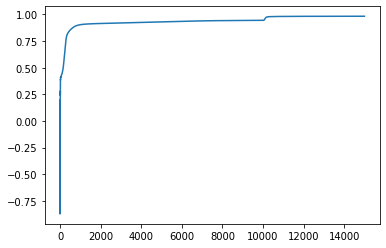

train l2 norm: 0.034212296103574284
train r2 score: 0.9825721002239263


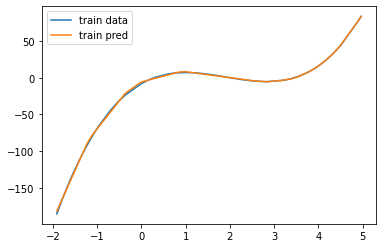

test l2 norm: 35.38160336497394
test r2 score: 0.21189775802533561


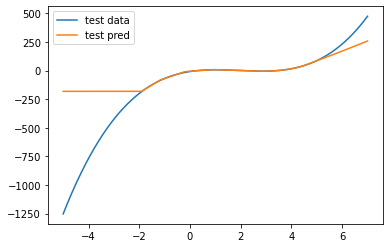

In [27]:
training_history, train_score, test_score = train(data, X, Y, test_data, test_X, test_Y, scale_x=True, scale_y=True, alpha=0.7, epochs=15000, batch_size=50, beta=0.9,
                    n_neurons_per_layer=[1, 50, 50, 50, 1], act_funcs=['relu','relu', 'relu', 'relu', 'linear'],
                    use_bias=True, problem='regression')

In [38]:
from tqdm import tqdm

In [50]:
scale_x = True
scale_y = True
alpha=0.7
epochs=2000
batch_size=50
beta=0.9
n_neurons_per_layer=[1, 50, 50, 50, 1]
act_funcs=['relu','relu', 'relu', 'relu', 'linear']
use_bias=True


train_scores = []
test_scores = []
for epochs in [100, 200, 500, 1000, 2000, 5000, 10000]:
    for seed in tqdm(range(30)):
        config = {'scale_x': scale_x,
                 'scale_y': scale_y,
                 'alpha': alpha,
                 'epochs': epochs,
                 'batch_size': batch_size,
                 'beta': beta,
                 'n_neurons_per_layer': n_neurons_per_layer,
                 'act_funcs': act_funcs,
                 'use_bias': use_bias}
        training_history, train_score, test_score = train(data, X, Y, test_data, test_X, test_Y, 
                                                          **config,
                                                          problem='regression', seed=seed, verbose=False)
        train_scores.append(train_score)
        test_scores.append(test_score)
        






  0%|          | 0/30 [00:00<?, ?it/s]




  3%|▎         | 1/30 [00:02<01:05,  2.27s/it]




  7%|▋         | 2/30 [00:04<01:03,  2.28s/it]




 10%|█         | 3/30 [00:06<01:01,  2.28s/it]




 13%|█▎        | 4/30 [00:09<00:58,  2.26s/it]




 17%|█▋        | 5/30 [00:11<00:56,  2.26s/it]




 20%|██        | 6/30 [00:13<00:54,  2.27s/it]




 23%|██▎       | 7/30 [00:16<00:53,  2.31s/it]




 27%|██▋       | 8/30 [00:18<00:50,  2.31s/it]




 30%|███       | 9/30 [00:20<00:49,  2.34s/it]




 33%|███▎      | 10/30 [00:23<00:47,  2.40s/it]




 37%|███▋      | 11/30 [00:25<00:45,  2.37s/it]




 40%|████      | 12/30 [00:28<00:45,  2.54s/it]




 43%|████▎     | 13/30 [00:30<00:42,  2.49s/it]




 47%|████▋     | 14/30 [00:33<00:39,  2.46s/it]




 50%|█████     | 15/30 [00:35<00:36,  2.43s/it]




 53%|█████▎    | 16/30 [00:38<00:34,  2.44s/it]




 57%|█████▋    | 17/30 [00:40<00:31,  2.39s/it]




 60%|██████    | 18/30 [00:42<00:28,  2.38s/it]




 63%|██████▎   | 19/30 [0

In [51]:
test_scores

[0.19302547931665104,
 0.19460970621365292,
 0.0806751858066308,
 0.077656960817584,
 0.19329984903609387,
 0.19305380344550938,
 0.19318118533126283,
 0.1927821384952334,
 0.193841249117086,
 0.0806337688464217,
 0.079832510110186,
 0.19208700995400674,
 0.19155790144944396,
 0.19237092445817427,
 0.08375311925414697,
 0.07739046423815987,
 0.07785506808177323,
 0.19305034641543584,
 0.19442831919209003,
 0.0787930355300791,
 0.07664343378471983,
 0.1951099685395622,
 0.19447830111984965,
 0.19501660685579736,
 0.07717210527535745,
 0.08117750598020301,
 0.07943486500777486,
 0.19237858546082887,
 0.19408482629993884,
 0.19253825000768787]

In [57]:
np.array(train_scores).mean()

0.7138216717924026

In [58]:
np.array(train_scores).std()

0.24234138024717894

In [59]:
np.array(test_scores).mean()

0.14773041578137805

In [60]:
np.array(test_scores).std()

0.05593254018727267

In [ ]:
#train_score, test_score, config